In [1]:
from astropy import table 
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as pyfits
from astropy.coordinates import SkyCoord
from astropy import units as u
import glob
import pickle
from collections import OrderedDict
import time
import emcee
from scipy import optimize, stats
import corner
from schwimmbad import MultiPool

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
table.Table(pyfits.open('/raid/DESI/catalogs/iron/rvtab-hpxcoadd-all.fits')[2].data)

TARGETID,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,cat_filename,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET
int64,int32,float64,float64,float32,float32,float32,int64,uint8,str3,float64,int32,int16,str8,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,str45,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
39628530270602267,0,25.194627023901567,32.52307303279818,0.0,0.0,2020.9597,20480,1,TGT,0.35656440190321204,1,9010,0252p325,508119,1051,PSF,0.041430227,0.11603739,0.47775656,3.10134,4.2916965,5.4735336,1036.3689,330.717,46.763256,3.5249295,0.8139606,0.09024163,0.37154862,2.411895,0.09709549,0.3820785,2.4361095,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,S,3400,1,20480,0,0,0,25.194627023901567,32.52307303279818,4,3600.0,1,1,0.0015,0.004636809,-0.00025,0.0035,25.194620218054094,0.087112986,32.523072355201066,0.05065097,0.789,21/2159/tab_coadd-cmx-other-2159.fits,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999
39628530270601815,0,25.15985933676262,32.40863816411243,-0.69415575,-2.5054495,2015.5,42949673511,3,TGT,0.41677074770602995,63,9010,0252p325,508119,599,PSF,0.044945452,112.27482,157.84695,172.41325,40.37286,22.818674,136.53688,53.236187,35.76261,2.5576394,0.7061526,87.42461,122.91009,134.25238,87.42464,122.91017,134.25252,0,0.0,0.0,0.0,0.0,303977276742747520,G2,17.068089,17.36322,16.619768,0.25238827,S,2679,100,42949673511,42949672960,0,0,25.15985933676262,32.40863816411243,4,3600.0,1,1,0.002,0.0064420495,-0.00125,0.005937171,25.15985029336862,0.12216852,32.408633670996714,0.084184535,0.789,21/2159/tab_coadd-cmx-other-2159.fits,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999
39628525145165785,0,24.759366151935428,32.13455410999437,0.0,0.0,2020.9597,20480,1,TGT,0.2843712894272945,1,9010,0246p322,506897,4057,PSF,0.051600385,0.101364225,0.41054899,3.0694313,5.311588,5.504041,1669.4165,557.0342,84.02333,3.4995997,0.7994719,0.07897575,0.31987038,2.3914812,0.07898624,0.31989264,2.3915153,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,S,3400,1,20480,0,0,0,24.759366151935428,32.13455410999437,4,3600.0,1,1,0.00325,0.003968627,0.0005,0.008972179,24.759350761649273,0.045037672,32.13455638575374,0.12816064,0.789,21/2159/tab_coadd-cmx-other-2159.fits,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999,999999
1152921504619435900,0,24.955284507414248,32.197888333199764,-2.1639938,1.1553857,2020.9597,140737488355328,1,TGT,0.35931855289650083,63,0,,0,0,,0.049809374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,303950712369947776,F1,20.219313,0.0,0.0,0.0,,4001,1,140737488355328,0,0,0,24.955284507414248,32.197888333199764,4,3600.0,1,1,0.0015,0.0035355338,0.00025,0.007826238,24.9552774837821

In [3]:
t1 = table.Table(pyfits.open('/raid/DESI/catalogs/iron/rvtab-hpxcoadd-all.fits')[1].data)
t1_fiber = table.Table(pyfits.open('/raid/DESI/catalogs/iron/rvtab-hpxcoadd-all.fits')[2].data)

t1_comb = table.hstack((t1,t1_fiber))

In [4]:
# sort based on the velocity uncertainty error, smallest one goes first
t1_comb.sort('VRAD_ERR')

In [5]:
print('# before unique selection:', len(t1_comb))

# do a unique selection based on TARGET ID. Keep the first one for duplicates 
# (and first one has the smallest RV error)
t1_unique = table.unique(t1_comb, keys='TARGETID_1', keep='first')
print('# after unique selection:', len(t1_unique))

# before unique selection: 6165491
# after unique selection: 6165491


In [6]:
dgmem = table.Table.read('/raid/other/dwarf_galaxy_mem_P03_gaiadr3_wDist_wFeH.fits')


            bootes_2         26     1
            bootes_3        125     6
    canes_venatici_1        166    24
    canes_venatici_2         17     4
    coma_berenices_1         47     5
             draco_1       1795   280
          hercules_1         51     7
               leo_1       1272     3
               leo_4          9     3
               leo_5          9     3
           pegasus_3          4     1
           sextans_1       1692   561
        ursa_major_1         54     2
        ursa_major_2         61    23
        ursa_minor_1       2243     1
           willman_1          9     1


Text(0.5, 1.0, 'iron')

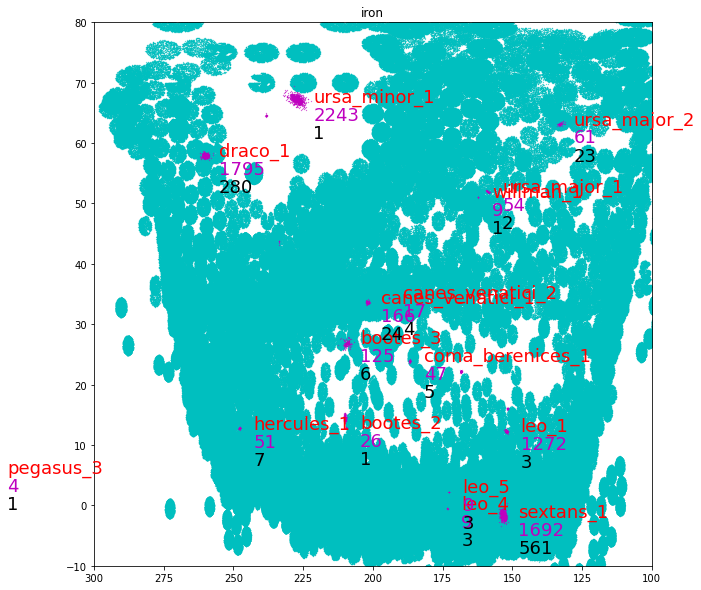

In [7]:
plt.figure(figsize=[10,10])
plt.plot(t1_unique['TARGET_RA_1'], t1_unique['TARGET_DEC_1'],'.c',ms=0.5)
plt.plot(dgmem['ra'],dgmem['dec'],'.m',ms=0.5)
naming = table.unique(dgmem, keys='key')

c = SkyCoord(ra=t1_unique['TARGET_RA_1']*u.degree, dec=t1_unique['TARGET_DEC_1']*u.degree)
catalog = SkyCoord(ra=dgmem['ra']*u.degree, dec=dgmem['dec']*u.degree)
match, d2d, d3d = c.match_to_catalog_sky(catalog)
dwarf_inDESI = dgmem[match][d2d < 0.3*u.arcsec]
desi_indwarf = t1_unique[d2d < 0.3*u.arcsec]

dwarf_comb = table.hstack((dwarf_inDESI,desi_indwarf))

for i in naming:
    #if i['RA']>180 and i['RA'] <350:
    if sum(dwarf_comb['key']==i['key'])>0:
        plt.text(i['ra']-5,i['dec'],i['key'], color='red', fontsize=18)
        plt.text(i['ra']-5,i['dec']-3,sum(dgmem['key']==i['key']), color='m', fontsize=18)
        plt.text(i['ra']-5,i['dec']-6,sum(dwarf_comb['key']==i['key']), color='k', fontsize=18)
        print('%20s %10i %5i'%(i['key'], sum(dgmem['key']==i['key']), sum(dwarf_comb['key']==i['key'])))
plt.xlim(300,100)
plt.ylim(-10,80)
plt.title('iron')

# build a mixture in metallicity and velocity on Draco and Sextans

In [8]:
def qual_sel(data):
    sel = data['VRAD'] > -600
    sel &= data['VRAD'] < 600
    sel &= data['VRAD_ERR'] < 10
    sel &= data['FEH'] > -3.98
    sel &= ~np.isnan(data['FEH_ERR'])
    sel &= ~np.isnan(data['FEH'])
    sel &= ~np.isnan(data['VRAD_ERR'])
    sel &= ~np.isnan(data['VRAD'])
    sel &= data['SUCCESS']
    sel &= data['SN_R']>2
    return sel


In [9]:
param_labels = ["pgal",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1"]
def lnprob(theta, rv, rverr, feh, feherr):
    """ Likelihood and Prior """
    pgal, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1 = theta
    
    ## The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or \
        (lsigv > 2) or (lsigvbg1 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or \
        (vbg1 > 500) or (vbg1 < -500):
        return -1e10 # outside of prior, return a tiny number
    
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    
    ## Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0,    scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
        
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh
    lbg1 = np.log(1-pgal) + lbg1_vhel + lbg1_feh
    ltot = np.logaddexp(lgal, lbg1)
    
    return np.sum(ltot)


param_labels_uni_bg = ["pgal", "vhel","lsigv","feh","lsigfeh"]

def lnprob_uni_bg(theta, rv, rverr, feh, feherr):
    """ Likelihood and Prior """
    pgal, \
    vhel, lsigv, feh0, lsigfeh = theta
    ## The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or \
        (lsigv > 2) or \
        (lsigv < -4) or \
        (lsigfeh > 1) or \
        (lsigfeh < -4):
        return -1e10 # outside of prior, return a tiny number
    
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.uniform.logpdf(rv, loc=-500, scale = 1000)
    
    ## Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0,    scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.uniform.logpdf(feh, loc=-4, scale=5)
        
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh
    lbg1 = np.log(1-pgal) + lbg1_vhel + lbg1_feh
    ltot = np.logaddexp(lgal, lbg1)
    
    return np.sum(ltot)



def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

def project_model(theta, rvmin=-500, rvmax=500, fehmin=-4, fehmax=1):
    """ Turn parameters into rv and feh distributions """
    params = get_paramdict(theta)
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    return rvarr, prv0, prv1, feharr, pfe0, pfe1

def project_model_uniform(theta, rvmin=-500, rvmax=500, fehmin=-4, fehmax=1):
    """ Turn parameters into rv and feh distributions """
    params = get_paramdict(theta)
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*stats.uniform.pdf(rvarr, loc=-500, scale=1000)
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*stats.uniform.pdf(feharr, loc=-4, scale=5)
    return rvarr, prv0, prv1, feharr, pfe0, pfe1


def plot_1d_distrs(theta):
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)

    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins='auto')
    xp, p0, p1 = model_output[0:3]
    ax.plot(xp, p0 + p1 , 'k-', label="Total", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.legend(fontsize='small')
    
    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1 = model_output[3:6]
    ax.plot(xp, p0 + p1 , 'k-', lw=3)
    ax.plot(xp, p1, ':', color=colors[1], lw=3)
    ax.plot(xp, p0, ':', color=colors[0], lw=3)
    return fig

def plot_1d_distrs_uniform(theta):
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model_uniform(theta)

    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins='auto')
    xp, p0, p1 = model_output[0:3]
    ax.plot(xp, p0 + p1 , 'k-', label="Total", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.legend(fontsize='small')
    
    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1 = model_output[3:6]
    ax.plot(xp, p0 + p1 , 'k-', lw=3)
    ax.plot(xp, p1, ':', color=colors[1], lw=3)
    ax.plot(xp, p0, ':', color=colors[0], lw=3)
    return fig


def plot_2d_distr(theta):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-400,400))
    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.grid()
    
    
def plot_2d_distr_uniform(theta):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-400,400))
    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.grid()
    
    
    
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))
    


In [10]:
def process_sys(rv, rverr, feh, feherr):
    p0_guess = [0.90, 
                np.median(rv), 1., np.median(feh), -0.3,
                0, 1.5, -1.0, -0.2]
    
    optfunc = lambda theta: -lnprob(theta, rv, rverr, feh, feherr)
    result = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")
    print(result.x)
    nparams = len(param_labels)
    nwalkers = 64
    p0 = result.x
    ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
    p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
    p0s[:,0][p0s[:,0]>1]=0.9999
    ## Check to see things are initialized ok
    #lkhds = [lnprob(p0s[j], rv, rverr, feh, feherr) for j in range(nwalkers)]
    #assert np.all(np.array(lkhds) > -9e9)

    ## Run emcee in parallel
    nproc = 4
    nstep = 1000

    with MultiPool(nproc) as pool:
        print("Running burnin with {} iterations".format(nstep))
        start = time.time()
        es = emcee.EnsembleSampler(
            nwalkers, len(p0), lnprob, args=(rv, rverr, feh, feherr), pool=pool) #guassian bg
        PP = es.run_mcmc(p0s, nstep)
        print("Took {:.1f} seconds".format(time.time()-start))

        print(f"Now running the actual thing")
        es.reset()
        start = time.time()
        es.run_mcmc(PP.coords, nstep)
        print("Took {:.1f} seconds".format(time.time()-start))

        chain = es.chain
        # Can save this output with np.save

    chain = es.flatchain
    return chain


def process_sys_uniform(rv, rverr, feh, feherr):

    p0_guess = [0.90, 
                np.median(rv), 0., np.median(feh), -0.3]
    
    #optfunc = lambda theta: -lnprob_uni_bg(theta, rv, rverr, feh, feherr)
    #result = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")
    #print(result.x)
    nparams = len(param_labels_uni_bg)
    nwalkers = 64
    p0 = p0_guess #result.x
    ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
    p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
    p0s[:,0][p0s[:,0]>1]=0.9999
    #print(p0s)
    ## Check to see things are initialized ok
    #lkhds = [lnprob(p0s[j], rv, rverr, feh, feherr) for j in range(nwalkers)]
    #assert np.all(np.array(lkhds) > -9e9)

    ## Run emcee in parallel
    nproc = 4
    nstep = 1000

    with MultiPool(nproc) as pool:
        print("Running burnin with {} iterations".format(nstep))
        start = time.time()
        es = emcee.EnsembleSampler(
            nwalkers, len(p0), lnprob_uni_bg, args=(rv, rverr, feh, feherr), pool=pool) #uniform bg
        PP = es.run_mcmc(p0s, nstep)
        print("Took {:.1f} seconds".format(time.time()-start))

        print(f"Now running the actual thing")
        es.reset()
        start = time.time()
        es.run_mcmc(PP.coords, nstep)
        print("Took {:.1f} seconds".format(time.time()-start))

        chain = es.chain
        # Can save this output with np.save

    chain = es.flatchain
    return chain


Working on...draco_1
find  280  possible members
[ 8.93740786e-01 -2.91510205e+02  1.11361575e+00 -2.21430005e+00
 -3.55621095e-01 -1.47800116e-03  2.20154692e+00 -9.37753332e-01
 -2.64011674e-01]
Running burnin with 1000 iterations
Took 13.1 seconds
Now running the actual thing
Took 14.9 seconds
pgal 0.887 0.019
vhel -291.542 0.861
lsigv 1.111 0.022
feh -2.216 0.030
lsigfeh -0.360 0.023
vbg1 -136.750 18.846
lsigvbg1 1.980 0.063
fehbg1 -0.958 0.113
lsigfeh1 -0.239 0.063


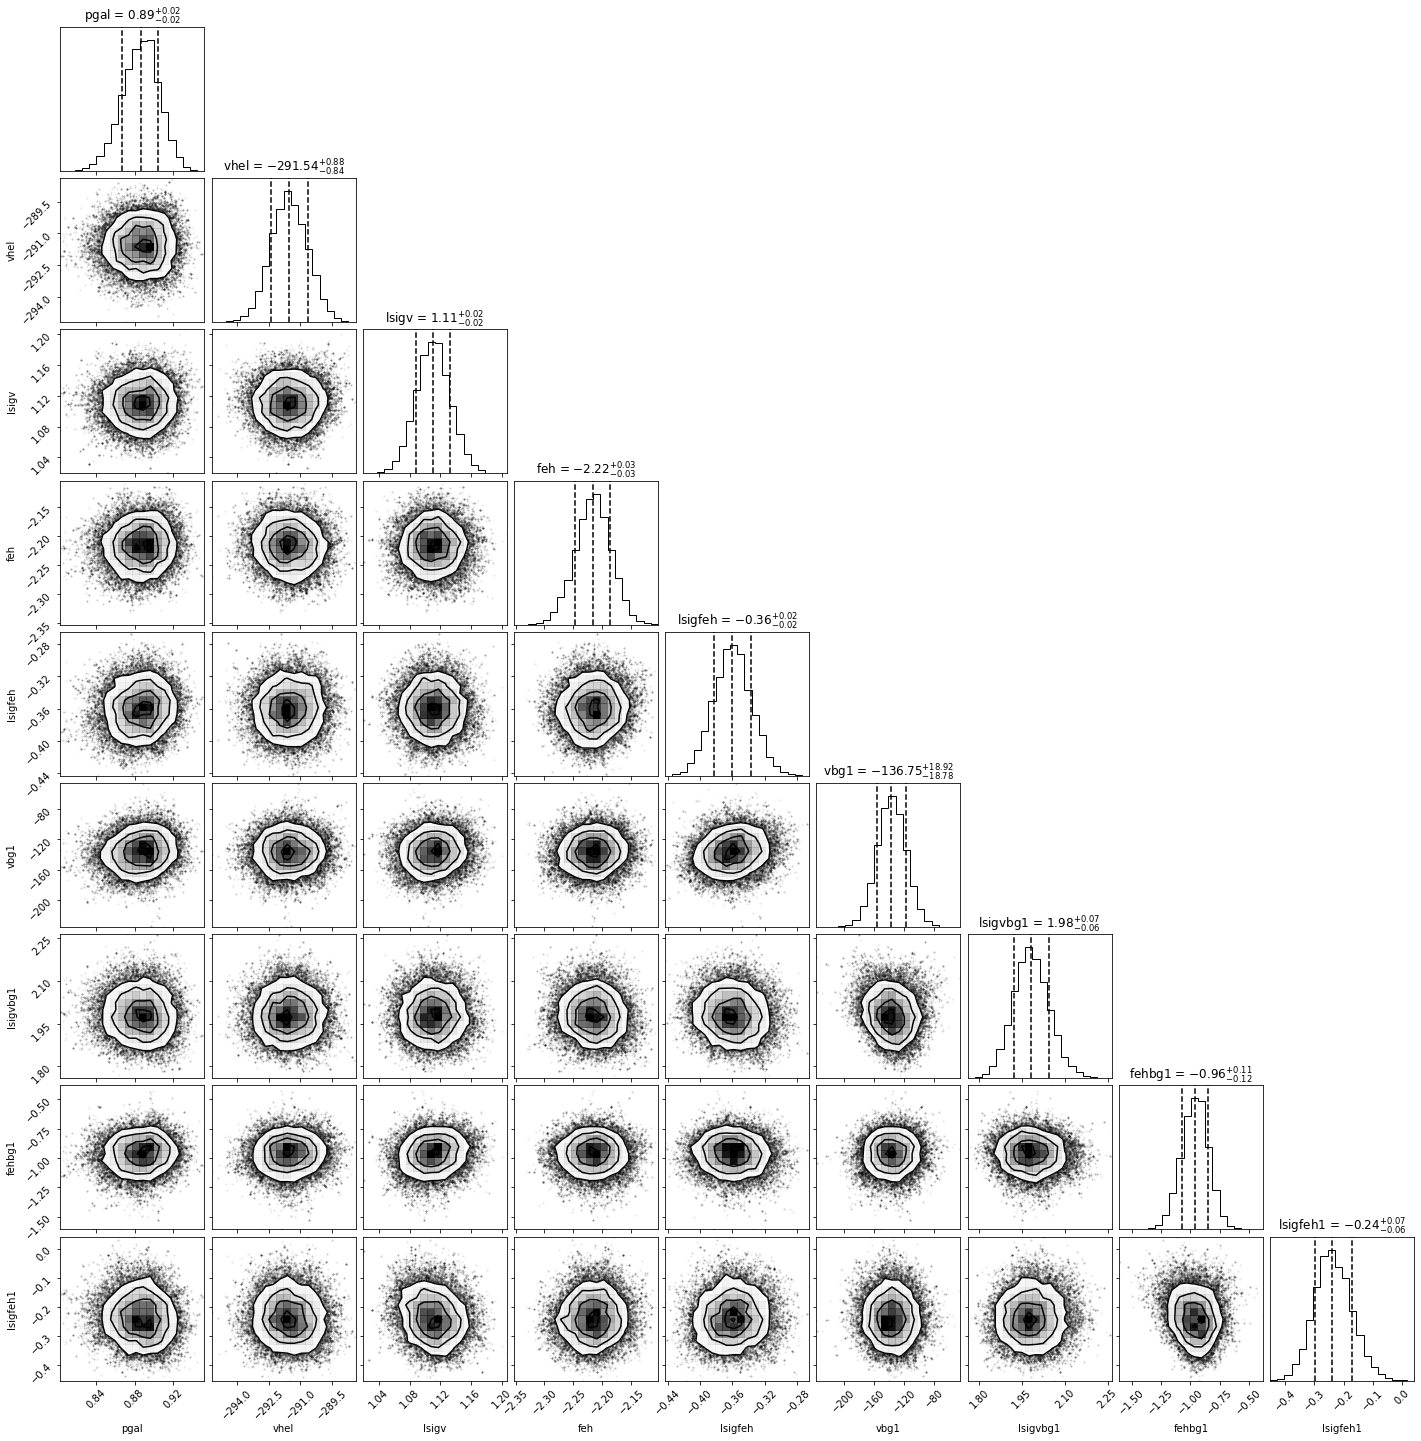

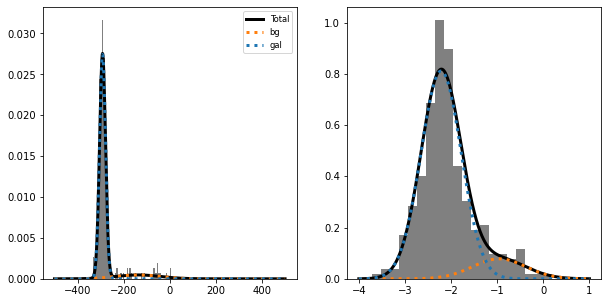

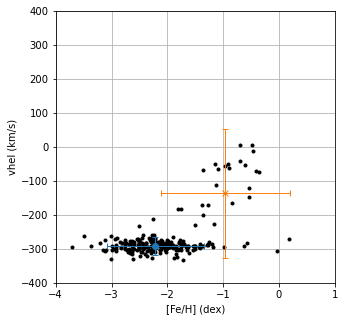

Working on...sextans_1
find  561  possible members
[ 8.74358518e-01  2.25857415e+02  9.48639159e-01 -2.17006720e+00
 -2.42991713e-01 -1.26655089e-03  1.82220827e+00 -8.89730517e-01
 -2.82587975e-01]
Running burnin with 1000 iterations
Took 13.4 seconds
Now running the actual thing
Took 13.8 seconds
pgal 0.872 0.024
vhel 225.871 0.770
lsigv 0.952 0.028
feh -2.169 0.043
lsigfeh -0.242 0.025
vbg1 50.892 9.358
lsigvbg1 1.642 0.073
fehbg1 -0.884 0.110
lsigfeh1 -0.264 0.071


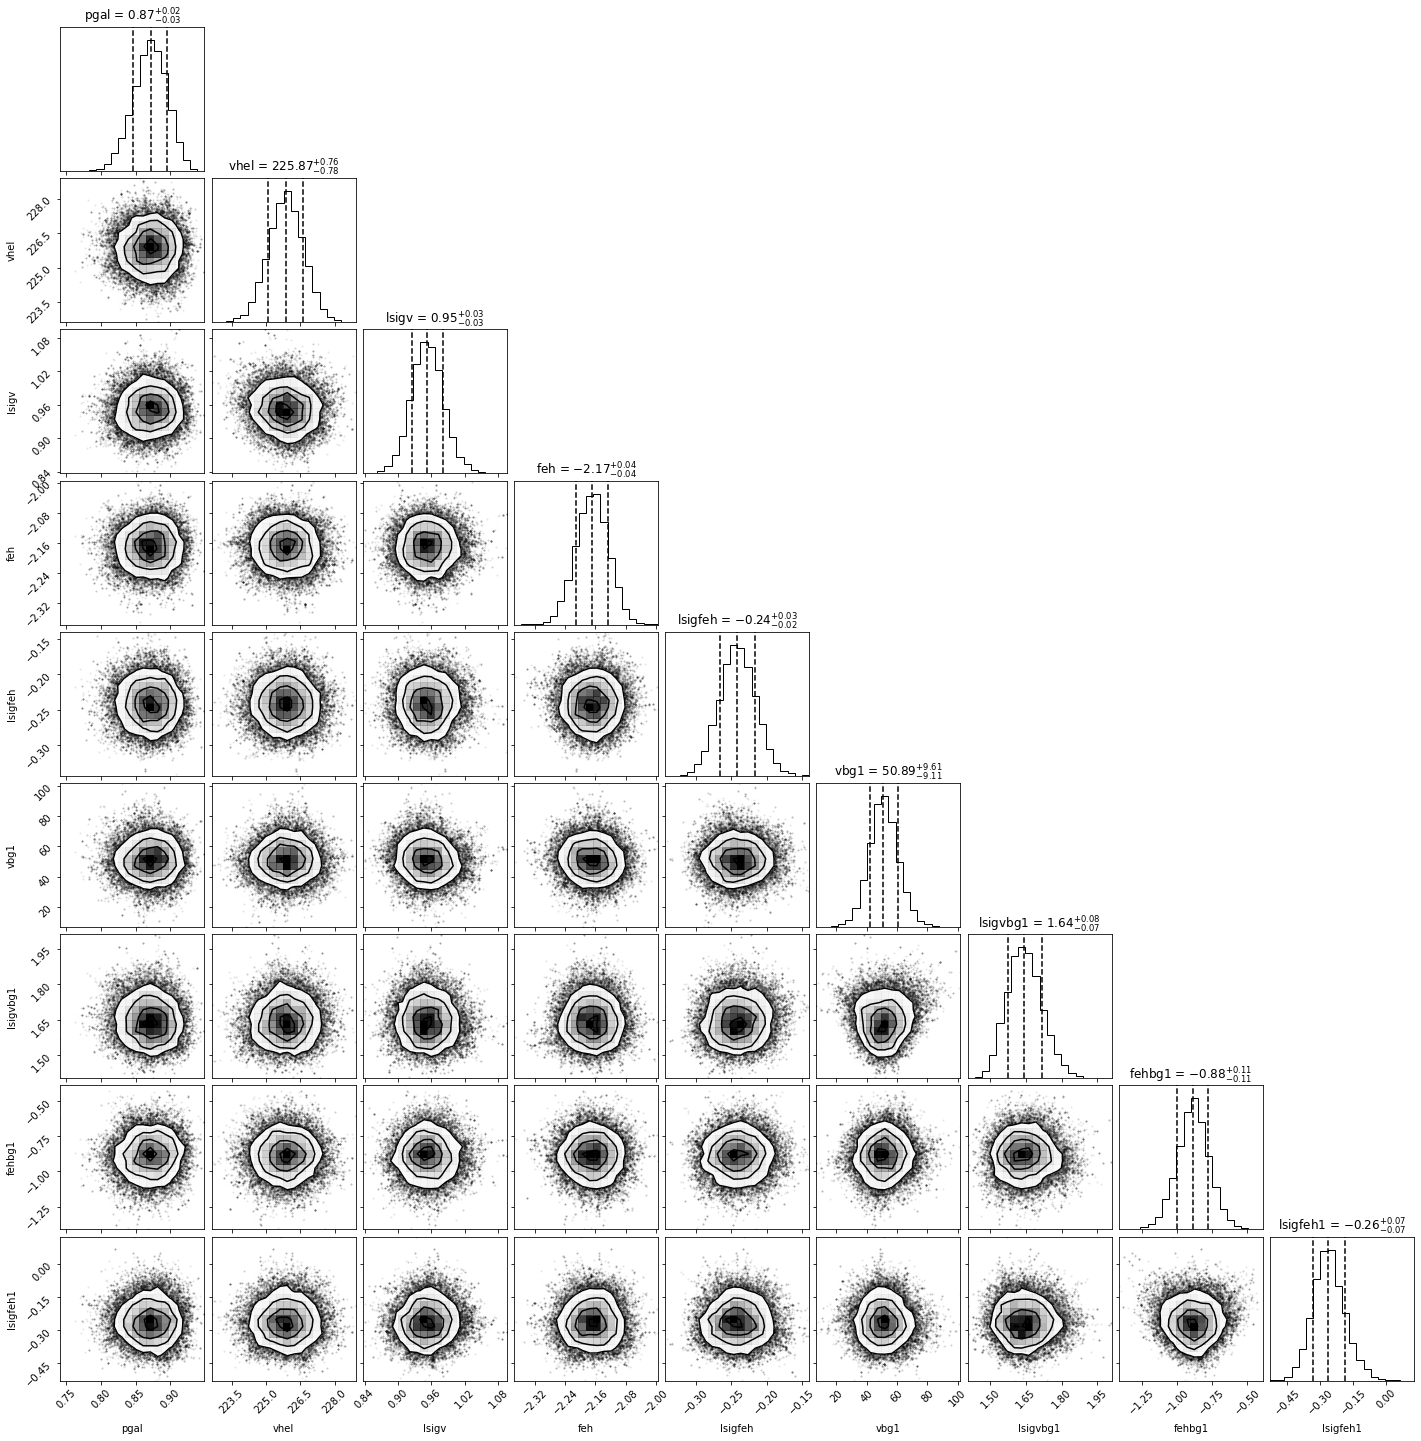

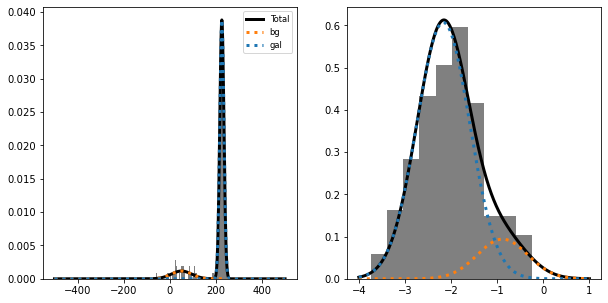

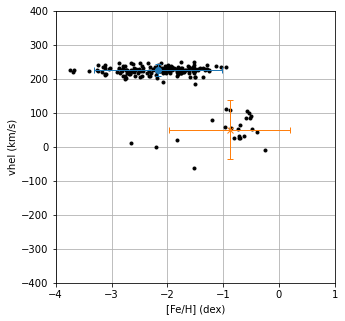

In [11]:
sum_chain = OrderedDict()

#for key in np.unique(dgmem['key']):
for key in ['draco_1','sextans_1']:
#for key in ['ursa_major_2']:
    print('Working on...' + key)
    dwarf = dgmem[dgmem['key']==key]
    try:
        c = SkyCoord(ra=t1_unique['TARGET_RA_1']*u.degree, dec=t1_unique['TARGET_DEC_1']*u.degree)
        catalog = SkyCoord(ra=dwarf['ra']*u.degree, dec=dwarf['dec']*u.degree)
        match, d2d, d3d = c.match_to_catalog_sky(catalog)
        dwarf_inDESI = dwarf[match][d2d < 0.5*u.arcsec]
        desi_indwarf = t1_unique[d2d < 0.5*u.arcsec]
        dwarf_comb = table.hstack((dwarf_inDESI,desi_indwarf))
        print('find ', len(dwarf_comb), ' possible members')
        if len(dwarf_comb)>10:
            rv = dwarf_comb['VRAD'][qual_sel(dwarf_comb)]
            rverr = np.sqrt(dwarf_comb['VRAD_ERR'][qual_sel(dwarf_comb)]**2+1.**2)
            feh = dwarf_comb['FEH'][qual_sel(dwarf_comb)]
            feherr = dwarf_comb['FEH_ERR'][qual_sel(dwarf_comb)]
            chain = process_sys(rv, rverr, feh, feherr)
            sum_chain[key] = chain
            try:
                fig = corner.corner(chain, labels=param_labels, quantiles=[0.16,0.50,0.84], show_titles=True)
            except:
                print('cannot make the corner plot')

            meds, errs = process_chain(chain)
            for k,v in meds.items():
                print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

            fig = plot_1d_distrs(meds.values())
            fig2 = plot_2d_distr(meds.values())
            plt.show()


        else:
            print('This System has less than 10 members in DESI')
    except:
        print('This System did not process successfully')
        
# create a binary pickle file 
f = open("dwarf_chain_normal_bg.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(sum_chain,f)

# close file
f.close()

Working on...draco_1
find  280  possible members
Running burnin with 1000 iterations
Took 19.3 seconds
Now running the actual thing
Took 20.4 seconds
pgal 0.883 0.020
vhel -291.595 0.857
lsigv 1.101 0.023
feh -2.206 0.030
lsigfeh -0.356 0.024


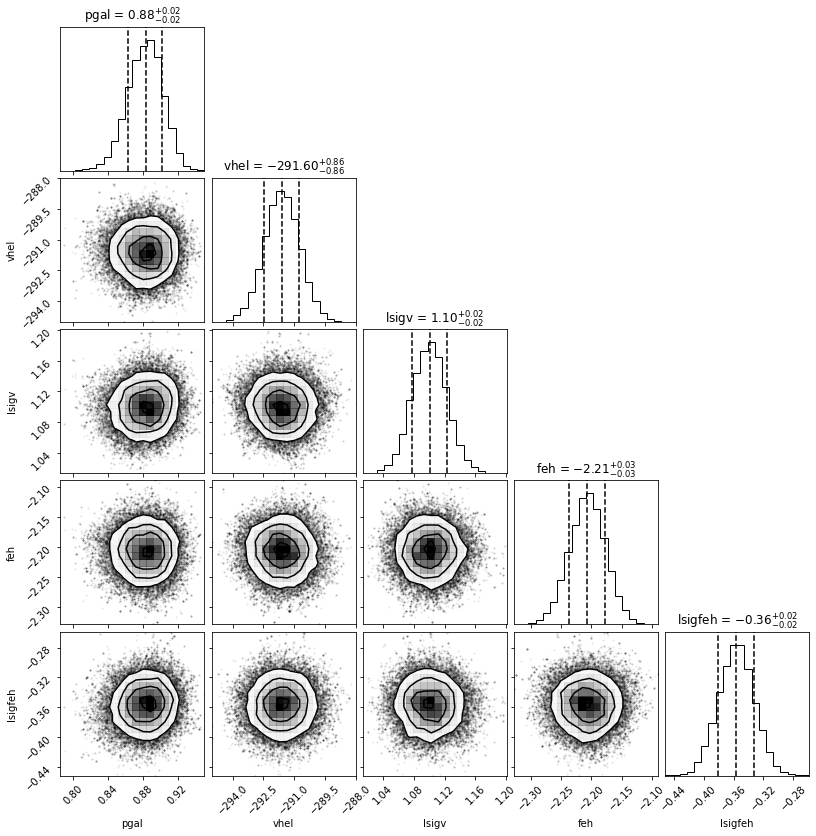

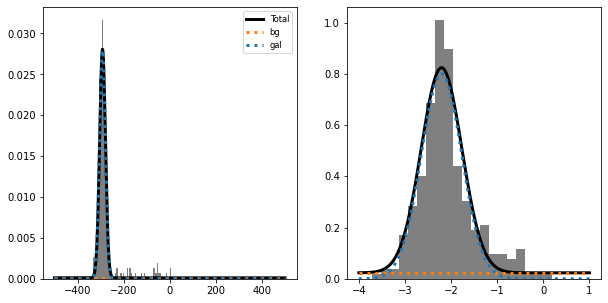

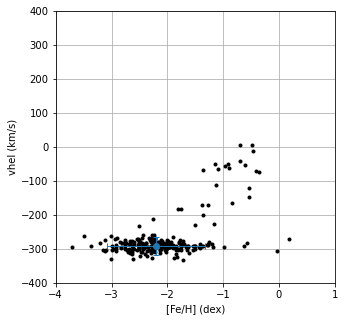

Working on...sextans_1
find  561  possible members
Running burnin with 1000 iterations
Took 20.5 seconds
Now running the actual thing
Took 20.3 seconds
pgal 0.865 0.026
vhel 225.886 0.754
lsigv 0.945 0.031
feh -2.168 0.045
lsigfeh -0.242 0.024


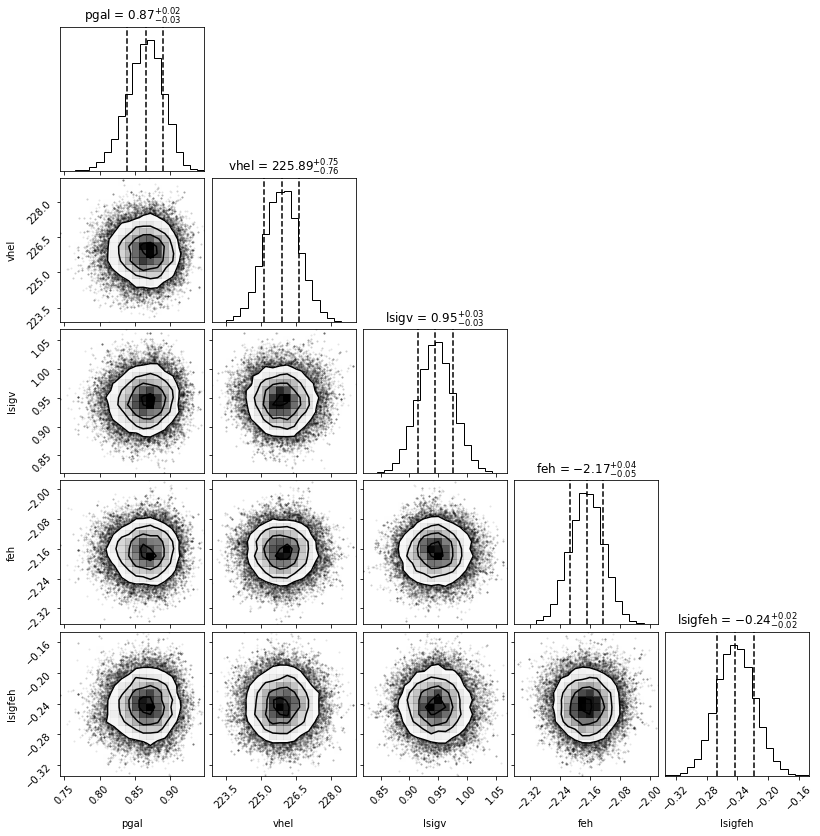

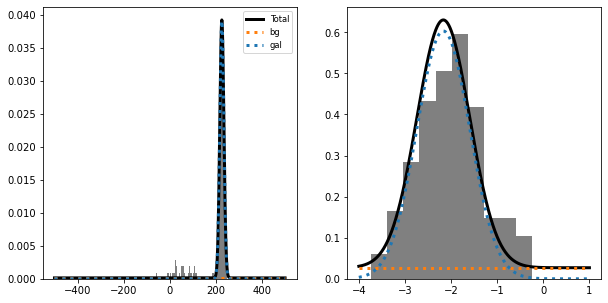

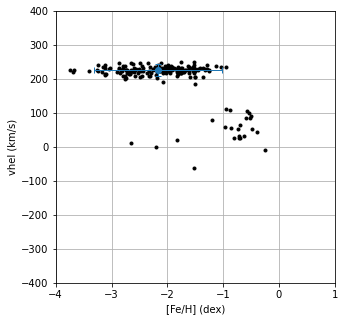

In [17]:
#run again but with uniform background

sum_chain = OrderedDict()

for key in ['draco_1','sextans_1']:
    print('Working on...' + key)
    dwarf = dgmem[dgmem['key']==key]
    try:
        c = SkyCoord(ra=t1_unique['TARGET_RA_1']*u.degree, dec=t1_unique['TARGET_DEC_1']*u.degree)
        catalog = SkyCoord(ra=dwarf['ra']*u.degree, dec=dwarf['dec']*u.degree)
        match, d2d, d3d = c.match_to_catalog_sky(catalog)
        dwarf_inDESI = dwarf[match][d2d < 0.5*u.arcsec]
        desi_indwarf = t1_unique[d2d < 0.5*u.arcsec]
        dwarf_comb = table.hstack((dwarf_inDESI,desi_indwarf))
        print('find ', len(dwarf_comb), ' possible members')
        if len(dwarf_comb)>10:
            rv = dwarf_comb['VRAD'][qual_sel(dwarf_comb)]
            rverr = np.sqrt(dwarf_comb['VRAD_ERR'][qual_sel(dwarf_comb)]**2+1.**2)
            feh = dwarf_comb['FEH'][qual_sel(dwarf_comb)]
            feherr = dwarf_comb['FEH_ERR'][qual_sel(dwarf_comb)]
            chain = process_sys_uniform(rv, rverr, feh, feherr)
            sum_chain[key] = chain
            try:
                fig = corner.corner(chain, labels=param_labels_uni_bg, quantiles=[0.16,0.50,0.84], show_titles=True)
            except:
                print('cannot make the corner plot')

            meds, errs = process_chain(chain)
            for k,v in meds.items():
                print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

            fig = plot_1d_distrs_uniform(meds.values())
            fig2 = plot_2d_distr_uniform(meds.values())
            plt.show()


        else:
            print('This System has less than 10 members in DESI')
    except:
        print('This System did not process successfully')
        

# create a binary pickle file 
f = open("dwarf_chain_uniform_bg.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(sum_chain,f)

# close file
f.close()